# Fase exploratória

In [ ]:
import sys
import os
from tqdm import tqdm
sys.path.append(os.path.abspath("../.."))

import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
import numpy as np
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

In [3]:
df_agg_cod = pd.read_excel(
    '../../datasets/intermediate/HS_agregado_codificado_20windows.xlsx')

## 1. Describe Variables

Calcular estatísticas descritivas básicas (`count`, `mean`, `std`, `min`, `25%`, `50%`, `75%`, `max`) para todas as colunas numéricas.

"Quais variáveis mais variam entre as janelas?"

In [4]:
desc = df_agg_cod.describe().T.sort_values("std", ascending=False)
desc

,count,mean,std,min,25%,50%,75%,max
auto_intersecoes_mean,1000.0,78640.774859,1.002989e+05,3591.981481,25846.042202,51329.803030,91652.975403,1.078025e+06
auto_intersecoes_std,1000.0,690.631897,7.274636e+02,40.847698,231.047330,348.193325,782.037291,3.572562e+03
mfcc_0_mean,1000.0,-105.318397,5.762209e+01,-326.816616,-132.124911,-100.249885,-64.259204,2.011215e+00
comprimento_curva_mean,1000.0,92.281934,4.154894e+01,6.669564,63.724397,87.720155,112.367695,2.567962e+02
freq_mean,1000.0,87.975950,4.075191e+01,37.388393,60.219029,72.247606,104.067251,2.440208e+02
...,...,...,...,...,...,...,...,...
rqa_rqa_threshold_mean,1000.0,0.100000,1.415731e-15,0.100000,0.100000,0.100000,0.100000,1.000000e-01
rqa_fs_mean,1000.0,800.000000,0.000000e+00,800.000000,800.000000,800.000000,800.000000,8.000000e+02
rqa_delay_mean,1000.0,2.000000,0.000000e+00,2.000000,2.000000,2.000000,2.000000,2.000000e+00
rqa_embedding_dim_mean,1000.0,5.000000,0.000000e+00,5.000000,5.000000,5.000000,5.000000,5.000000e+00


In [60]:
desc.to_excel("teste.xlsx")

Variáveis com maior variabilidade (alto desvio padrão (`std`))

| Variável                 | Interpretação                                                                         |
| ------------------------ | ------------------------------------------------------------------------------------- |
| `auto_intersecoes_mean`  | Varia muito de janela pra janela → sinal de **alta complexidade geométrica**          |
| `mfcc_0_mean`            | É a energia espectral global (1º coef. cepstral) → **bom sinal** que ele varia        |
| `comprimento_curva_mean` | Relacionado a densidade da winding → diferencia sons mais “longos” ou “curtos”        |
| `freq_mean`              | Frequência dominante média da janela → variação natural esperada em sons fisiológicos |

Ou seja, essas são as _features_  mais "vivas" do nosso dataset, as que provavelmente poderão ajudar os modelos a distinguir entre as classes.

Enquanto isso, as _features_ com menos variabilidade (desvio padrão (`std=0`)) são 

| Variável                 | Interpretação                                                                         |
| ------------------------ | ------------------------------------------------------------------------------------- |
| `rqa_fs_mean	`           | Pois tem o valor fixo de 800. Taxa de amostragem usada no RQA, é esperada como constante         |
| `rqa_delay_mean`         | Valor fixo  =  2. Delay usado no embedding, fixado como hiperparâmetro, normal       |
| `rqa_embedding_dim_mean` | Dimensão do embedding, também fixada no código, esperado        |
| `rms_energy_std`         | Porque a energia já foi calculada uma única vez por janela.|

Ou seja, nenhuma dessas colunas com variabilidade nula apresentam alguma inconsistência até então, mas não são informativas para modelos de aprendizado supervisionado por não terem variação e não contribuirem para separação de classes.



In [5]:
df_agg_cod = df_agg_cod.drop(
    columns=['rqa_fs_mean', 'rqa_delay_mean', 'rqa_embedding_dim_mean', 'rms_energy_std' ])

## 2. Correlograma das principais variáveis (top 20 std)


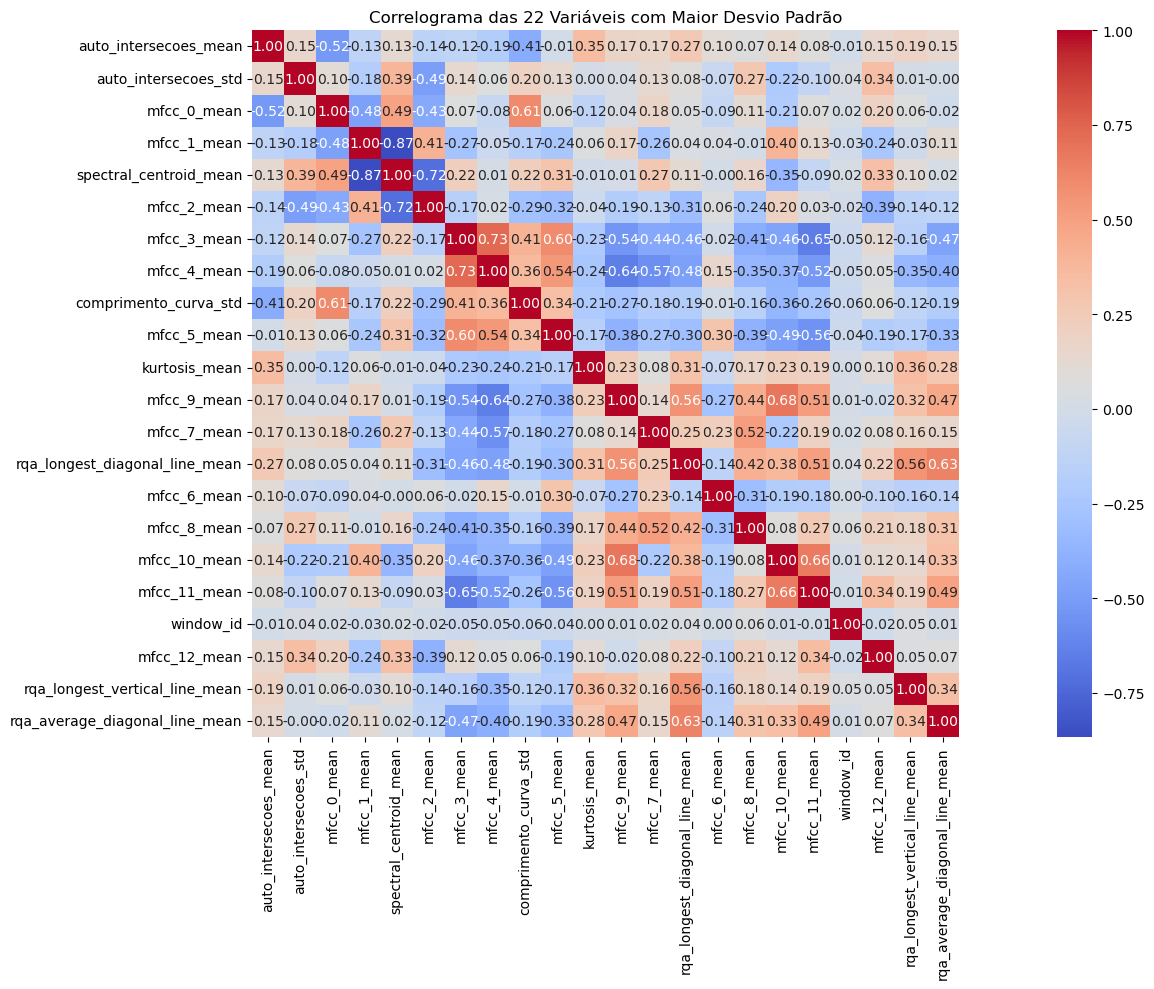

In [8]:
top_vars = desc.head(22).index.tolist()
corr = df_agg_cod[top_vars].corr()

plt.figure(figsize=(20, 10))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", square=True)
plt.title("Correlograma das 22 Variáveis com Maior Desvio Padrão")
plt.tight_layout()
plt.show()

O Heatmap de correlação de Pearson entre as 22 variáveis com maior desvio padrão do dataset agregado por janela nos diz que há alta correlação (redundância potencial) entre:

* `mfcc_0_mean`:
     * `comprimento_curva_mean` (r=0.83)
     * `comprimento_curva_std` (r=0.62)

* `freq_mean`:
     * `freq_std` (r=0.77)
     * `spectral_centroid_mean` (r=.92)

* `mfcc_3_mean`:
     * `mfcc_4_mean` (r=0.70)

* `mfcc_9_mean`:
     * `mfcc_10_mean` (r=0.65)


DECISÃO PROVISÓRIA: 
- deletar as _features_ de maior correlação com outras:


In [7]:
df_agg_cod = df_agg_cod.drop(
    columns=['freq_mean', 'comprimento_curva_mean', 'has_trapping_mean', 'freq_std'], errors='ignore')
desc = df_agg_cod.describe().T.sort_values("std", ascending=False)

In [105]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# import numpy as np

# # Copiar base
# df_features = df_agg_cod.copy()

# # Identificar MFCCs
# mfcc_cols = [
#     col for col in df_features.columns if "mfcc_" in col and "_mean" in col]

# # OUTRA FEATURES: manter apenas colunas numéricas úteis (sem redundâncias e constantes)
# non_mfcc_cols = [
#     col for col in df_features.select_dtypes(include=["float64", "int"]).columns
#     if col not in mfcc_cols + ["window_id"] and not col.endswith("_std")
# ]

# # X_A: versão com MFCCs selecionados manualmente (os menos correlacionados)
# mfcc_selected = ["mfcc_0_mean", "mfcc_3_mean", "mfcc_9_mean"]
# X_A = df_features[mfcc_selected + non_mfcc_cols].copy()

# # X_B: versão com PCA nos MFCCs (3 componentes)
# scaler = StandardScaler()
# X_mfcc_scaled = scaler.fit_transform(df_features[mfcc_cols])
# pca = PCA(n_components=3)
# X_mfcc_pca = pca.fit_transform(X_mfcc_scaled)

# # Nomear colunas PCA
# df_pca_mfcc = pd.DataFrame(
#     X_mfcc_pca, columns=["mfcc_pca_1", "mfcc_pca_2", "mfcc_pca_3"])
# df_pca_mfcc.index = df_features.index  # garantir alinhamento

# X_B = pd.concat([df_pca_mfcc, df_features[non_mfcc_cols]], axis=1)
# del X_B['has_trapping_mean']
# del X_B['freq_mean']


## 3. ANOVA entre classes (usando argmax da codificação one-hot como label)

ANOVA - Analysis of Variance

Um teste estatístico que responde à pergunta:

“Essa variável é diferente entre os grupos (classes) ou não?”

In [ ]:
one_hot_cols = [c for c in df_agg_cod.columns if "Heart Sound Type_" in c]
df_agg_cod["label"] = df_agg_cod[one_hot_cols].idxmax(axis=1)

anova_results = {}
for var in top_vars:
    groups = [df_agg_cod[df_agg_cod["label"] == cls][var]
              for cls in df_agg_cod["label"].unique()]
    anova_results[var] = f_oneway(*groups).pvalue

sorted_anova = dict(sorted(anova_results.items(), key=lambda x: x[1]))

Então, para avaliar a **capacidade discriminativa de cada variável** em relação às classes (tipos de som cardíaco), aplicamos a técnica de ANOVA One-Way, comparando as médias das variáveis contínuas entre os diferentes grupos.


No nosso caso:
- Cada classe é um tipo de som cardíaco (ex: S3, S4, Murmur etc.);

- Cada variável (ex: mfcc_3_mean, kurtosis_mean, rqa_entropy) é testada para ver se sua média varia significativamente entre as classes.

- Se o p-valor for pequeno (< 0.05) → a variável é relevante para separar classes;

- Se o p-valor for alto (> 0.05) → a variável não ajuda muito na separação.

In [10]:
sorted_anova

{'mfcc_2_mean': np.float64(2.6997822981358e-165),
 'mfcc_9_mean': np.float64(6.893988740765857e-165),
 'mfcc_4_mean': np.float64(6.2371097474933225e-161),
 'spectral_centroid_mean': np.float64(3.0433504078523383e-159),
 'mfcc_10_mean': np.float64(3.268430460364034e-153),
 'mfcc_12_mean': np.float64(1.2031820907363676e-133),
 'mfcc_1_mean': np.float64(4.3323893639934174e-117),
 'mfcc_11_mean': np.float64(1.434431421211347e-108),
 'mfcc_3_mean': np.float64(4.6781139985511734e-105),
 'auto_intersecoes_std': np.float64(6.524329023330869e-81),
 'mfcc_8_mean': np.float64(3.952982097458352e-72),
 'mfcc_7_mean': np.float64(9.947257525949077e-72),
 'rqa_longest_diagonal_line_mean': np.float64(1.4975386076362905e-67),
 'mfcc_0_mean': np.float64(3.444088474699767e-65),
 'mfcc_5_mean': np.float64(3.5224868464643676e-61),
 'mfcc_6_mean': np.float64(2.343508648052459e-57),
 'rqa_average_diagonal_line_mean': np.float64(1.0380469117692932e-54),
 'auto_intersecoes_mean': np.float64(9.309235534325892e-4

p-valores extremamente baixos indicam que essas variáveis são **altamente relevantes para diferenciar entre classes** de sons cardíacos. Variáveis como MFCCs, auto-interseções e métricas RQA se destacam como mais informativas.

## 4. UMAP e t-SNE para separação não linear


- O StandardScaler é aplicado para normalizar os dados antes da redução dimensional.

- Um PCA inicial com 30 componentes foi utilizado antes do t-SNE para reduzir ruído e acelerar o processo.

- O t-SNE foi aplicado com:

     - `n_components=2`: projetando os dados para duas dimensões.

     - `perplexity=30`: define o tamanho do “contexto” considerado localmente em torno de cada ponto (ajuste fino de agrupamentos).

t-SNE sem PCA pode se perder em ruído. PCA --> t-SNE é uma estratégia clássica para manter estrutura relevante e reduzir overfitting visual.

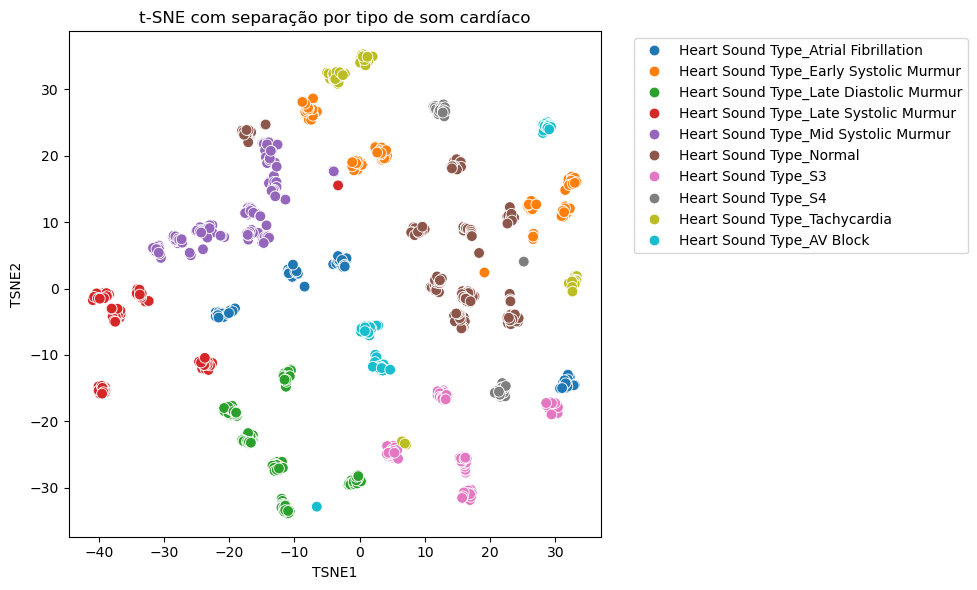

In [ ]:
X = df_agg_cod.select_dtypes(include=["float64", "int"]).drop(
    columns=["window_id"], errors="ignore")
y = df_agg_cod["label"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=30)
X_pca = pca.fit_transform(X_scaled)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_pca)

df_agg_cod["TSNE1"] = X_tsne[:, 0]
df_agg_cod["TSNE2"] = X_tsne[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_agg_cod, x="TSNE1", y="TSNE2",
                hue="label", palette="tab10", s=60)
plt.title("t-SNE com separação por tipo de som cardíaco")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

As classes como Normal, S3, S4, Murmúrios sistólicos, AV Block e Tachycardia aparecem bem agrupadas e espacialmente separadas. Isso sugere uma forte separabilidade não linear, ou seja, modelos como SVM com kernel RBF, ou redes neurais simples, podem funcionar bem para essas classes. Algumas classes (ex: S4, AV Block) aparecem com agrupamentos quase esféricos e isolados, o que é um bom indicativo de precisão esperada.

## 5. Importância das variáveis (com _RandomForest_)


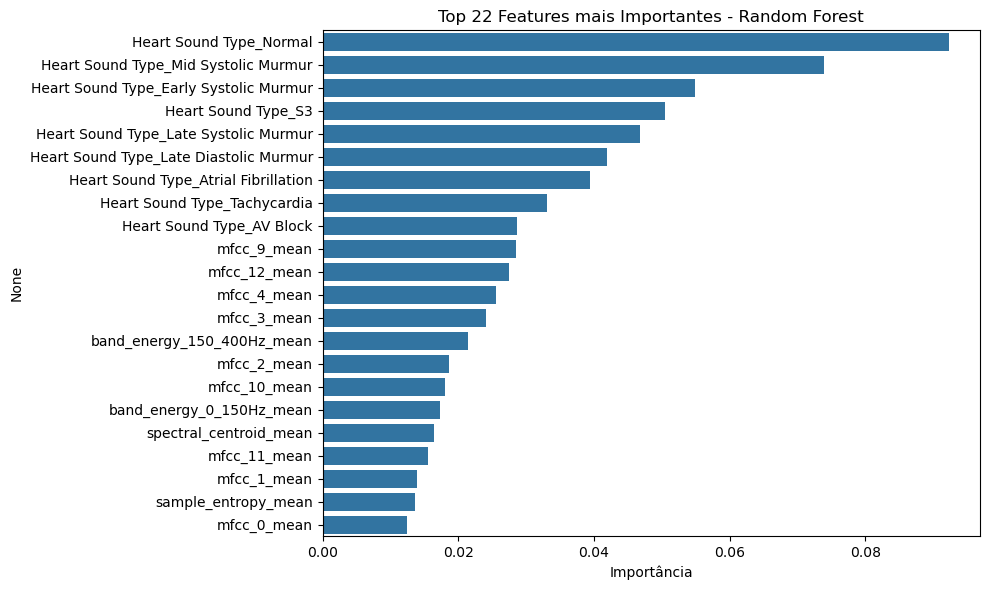

(Heart Sound Type_Normal                   0.092318
 Heart Sound Type_Mid Systolic Murmur      0.073989
 Heart Sound Type_Early Systolic Murmur    0.054841
 Heart Sound Type_S3                       0.050415
 Heart Sound Type_Late Systolic Murmur     0.046772
 Heart Sound Type_Late Diastolic Murmur    0.041931
 Heart Sound Type_Atrial Fibrillation      0.039411
 Heart Sound Type_Tachycardia              0.033131
 Heart Sound Type_AV Block                 0.028649
 mfcc_9_mean                               0.028546
 mfcc_12_mean                              0.027489
 mfcc_4_mean                               0.025612
 mfcc_3_mean                               0.024017
 band_energy_150_400Hz_mean                0.021406
 mfcc_2_mean                               0.018634
 mfcc_10_mean                              0.017992
 band_energy_0_150Hz_mean                  0.017321
 spectral_centroid_mean                    0.016483
 mfcc_11_mean                              0.015496
 mfcc_1_mean

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False).head(22)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances_sorted.values, y=importances_sorted.index)
plt.title("Top 22 Features mais Importantes - Random Forest")
plt.xlabel("Importância")
plt.tight_layout()
plt.show()

importances_sorted, sorted_anova

O modelo Random Forest foi treinado sobre os dados normalizados (X_scaled) e as classes (y).

A importância de cada variável foi calculada com base na capacidade de redução de impureza (Gini) em cada árvore da floresta.

O gráfico de barras mostra as 22 variáveis mais importantes, com destaque para:

- Variáveis categóricas one-hot dos rótulos (Heart Sound Type_X), o que é esperado, pois elas são as verdadeiras classes (e estão sendo tratadas como features — aqui pode haver um erro conceitual, se elas estavam de fato na matriz X).

- Depois, aparecem variáveis do tipo:

     - mfcc_9_mean, mfcc_12_mean, mfcc_4_mean etc.

     - band_energy_150_400Hz_mean

     - spectral_centroid_mean

     - sample_entropy_mean

Essas coincidem com os resultados da ANOVA realizada anteriormente, o que valida sua importância estatística e empírica.



## 6. Separação Não-Linear: PCA e t-SNE

O PCA (Principal Component Analysis) reduz a dimensionalidade do dataset projetando os dados em componentes principais que preservam a **variância máxima**. É útil para visualizar a estrutura global dos dados. O t-SNE (t-distributed Stochastic Neighbor Embedding) é uma técnica não-linear que foca em preservar **relações locais** entre os pontos. É mais adequado quando queremos identificar **aglomerados ou separações sutis** entre as classes.



In [ ]:
numeric_cols = df_agg_cod.select_dtypes(
    include=["float64", "int"]).columns.drop("window_id", errors="ignore")

X_scaled = StandardScaler().fit_transform(df_agg_cod[numeric_cols])
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

df_plot = df_agg_cod.copy()
df_plot["pca_1"] = X_pca[:, 0]
df_plot["pca_2"] = X_pca[:, 1]
df_plot["pca_3"] = X_pca[:, 2]

fig = px.scatter_3d(
    df_plot,
    x="pca_1",
    y="pca_2",
    z="pca_3",
    color="label",
    opacity=0.8,
    title="Separação das classes via PCA (3D)"
)
fig.show()

No gráfico 3D gerado pelo PCA, observamos uma **boa separação** para algumas classes como:

- **AV Block** (bloco AV)
- **Tachycardia**
- **S3, S4**  
- **Murmúrios Sistólicos**

Classes como **Normal**, **S3** e **S4** apresentaram dispersões que ainda permitem certa separação espacial entre si.


In [ ]:
df = df_agg_cod.copy()

label_col = [c for c in df.columns if c.startswith("Heart Sound Type_")]
df["label"] = df[label_col].idxmax(axis=1)

# Separar features numéricas
X = df.select_dtypes(include="number").drop(
    columns=["window_id"], errors="ignore")
X = X.drop(columns=label_col, errors="ignore")

# Normalização
X_scaled = StandardScaler().fit_transform(X)

# t-SNE em 3D
tsne = TSNE(n_components=3, perplexity=30, random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

df["tsne_1"] = X_tsne[:, 0]
df["tsne_2"] = X_tsne[:, 1]
df["tsne_3"] = X_tsne[:, 2]

fig = px.scatter_3d(df, x="tsne_1", y="tsne_2", z="tsne_3", color="label",
                    title="t-SNE (3D) - Separação por tipo de som cardíaco",
                    opacity=0.8)
fig.show()

c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



O t-SNE confirmou os agrupamentos observados no PCA, com separações ainda mais acentuadas para:

- **AV Block**
- **Tachycardia**
- **Late Diastolic Murmur**
- **Normal**
- **S3 / S4** em regiões parcialmente isoladas

Esses resultados sugerem **forte potencial separativo** entre várias classes mesmo com um dataset relativamente pequeno.
